<a href="https://colab.research.google.com/github/matt-cornelius/Flip/blob/main/Project/Neural_Net_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello Prof Flynn.  This is my starting point for my neural net project on identifying gender based on word choice measured from twitter posts.  The last dataset I showed you two weeks ago actually had a few shortcomings so I found [this one](https://www.kaggle.com/datasets/crowdflower/twitter-user-gender-classification/data) which is much better and has more downloads and commentary so I feel it's more reliable.  There are a couple cons.  First, each post is either labeled male, female, or brand (as in a company brand).  They are labeled by human contributors so it's likely there is a non-negligible amount of error in labeling.  Nevertheless, I'm interested in it as a gender predictor and even as a predictor of if I'm reading a post from a human (label is !brand).

The dataset contains 20,000 rows, each with a user name, a random tweet, account profile and image, location, and even link and sidebar color.  This is a reasonably large number.  I think large enough for my purposes.  On the about page on Kaggle it says the dataset was used to "train a CrowdFlower AI gender predictor" so I feel reasonably confident everything I discussed two weeks ago about my project goals (and a bit more) will be possible with this dataset.  Below, I unzip the downloaded file and inspected some of the data in the last few cells.  Everything looks all right to me.  Let me know what you think!

In [1]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mattcorn","key":"f8041f9cc1f8d42cf8c2aa357c50c6f6"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file

In [3]:
!kaggle datasets download -d crowdflower/twitter-user-gender-classification

Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-user-gender-classification
License(s): CC0-1.0
twitter-user-gender-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip -q twitter-user-gender-classification.zip -d gender-classifier-DFE

replace gender-classifier-DFE/gender-classifier-DFE-791531.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [5]:
import os

dataset_path = "gender-classifier-DFE"  # Change if your dataset is in a different folder
os.listdir(dataset_path)


['gender-classifier-DFE-791531.csv']

In [6]:
import pandas as pd

file_path = os.path.join(dataset_path, "gender-classifier-DFE-791531.csv")
df = pd.read_csv(file_path, encoding="latin1")
df.head()


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [7]:
# clean the data now

# Keep only the relevant columns
df = df[['text', 'gender', 'gender:confidence']]

# Drop rows with missing values in these columns
df = df.dropna()

# Filter to only rows with high confidence labels
df = df[df['gender:confidence'] >= 0.8]

# Keep only the 3 target classes
df = df[df['gender'].isin(['male', 'female', 'brand'])]

# Reset index for cleanliness
df = df.reset_index(drop=True)

# Check result
df.head()


,text,gender,gender:confidence
0,Robbie E Responds To Critics After Win Against...,male,1.0
1,ÛÏIt felt like they were my friends and I was...,male,1.0
2,Hi @JordanSpieth - Looking at the url - do you...,male,1.0
3,Watching Neighbours on Sky+ catching up with t...,female,1.0
4,"Ive seen people on the train with lamps, chair...",female,1.0


In [8]:
import re

def clean_tweet(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove @mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply the cleaning function
df['clean_text'] = df['text'].apply(clean_tweet)

# Check result
df[['text', 'clean_text']].head()


,text,clean_text
0,Robbie E Responds To Critics After Win Against...,robbie e responds to critics after win against...
1,ÛÏIt felt like they were my friends and I was...,ûïit felt like they were my friends and i was ...
2,Hi @JordanSpieth - Looking at the url - do you...,hi looking at the url do you use dont typicall...
3,Watching Neighbours on Sky+ catching up with t...,watching neighbours on sky catching up with th...
4,"Ive seen people on the train with lamps, chair...",ive seen people on the train with lamps chairs...


In [9]:
df.columns


Index(['text', 'gender', 'gender:confidence', 'clean_text'], dtype='object')

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13817 entries, 0 to 13816
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               13817 non-null  object 
 1   gender             13817 non-null  object 
 2   gender:confidence  13817 non-null  float64
 3   clean_text         13817 non-null  object 
dtypes: float64(1), object(3)
memory usage: 431.9+ KB


In [11]:
df.sample(5)


,text,gender,gender:confidence,clean_text
1536,@LeeDingain @HoundsOff @StainesMoor The best b...,male,1.0,the best bit of autumn
13421,If it didn't cause a massive brawl and ww2 I'd...,female,1.0,if it didnt cause a massive brawl and ww id te...
631,@Alicia20M I know it's annoying. It's cold for...,male,1.0,i know its annoying its cold for a couple minu...
3008,Go watch the new video @1245Josh,female,1.0,go watch the new video
5106,"I never heard Prior, but i can dig Eddie Murph...",male,1.0,i never heard prior but i can dig eddie murphy...


In [12]:
label_map = {'male': 0, 'female': 1, 'brand': 2}
df['gender_encoded'] = df['gender'].map(label_map)
df[['gender', 'gender_encoded']].head()


,gender,gender_encoded
0,male,0
1,male,0
2,male,0
3,female,1
4,female,1


In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])
print(label_encoder.classes_)


['brand' 'female' 'male']


In [14]:
# Filter out 'unknown' and NaN labels
df = df[df['gender'].isin(['male', 'female', 'brand'])]

# Re-encode labels after filtering
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])
print(label_encoder.classes_)


['brand' 'female' 'male']


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to 5000 most common words
X = vectorizer.fit_transform(df['clean_text'])


In [16]:
from sklearn.model_selection import train_test_split

y = df['gender_encoded']
X = vectorizer.fit_transform(df['clean_text'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       brand       0.63      0.59      0.61       763
      female       0.59      0.64      0.61      1089
        male       0.47      0.44      0.45       912

    accuracy                           0.56      2764
   macro avg       0.56      0.56      0.56      2764
weighted avg       0.56      0.56      0.56      2764



**Milestone 2 Deliverables**

*This code is now obsolete.

We are going to use a FCN to start as my first architecture. We'll do this with TensorFlow.

To implement FCN, I'll set up the following:
- Input: TF-IDF vectors

- Dense layers: maybe 2-3 layers

- Output: softmax activation for 3 classes (male, female, brand)

- Loss: categorical crossentropy

- Metric: accuracy

Next, I'll train on a few epochs (I only need a few to try out).
Then, at the end, I'll report:
- Model architecture summary

- Training loss and accuracy

- Test accuracy

- Plot accuracy and loss graphs



In [ ]:
#import tensorflow as tf
#from tensorflow.keras import layers, models
#from sklearn.preprocessing import LabelBinarizer

## Binarize labels for categorical crossentropy
#lb = LabelBinarizer()
#y_binarized = lb.fit_transform(y)

# Train-test split again with binarized labels
#X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.2, random_state=42)

# Build the model
#model = models.Sequential()
#model.add(layers.InputLayer(shape=(X.shape[1],)))
#model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(3, activation='softmax'))  # 3 classes

# Compile
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
#history = model.fit(X_train.toarray(), y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate
#loss, accuracy = model.evaluate(X_test.toarray(), y_test)
#print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/5
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4598 - loss: 1.0155 - val_accuracy: 0.5464 - val_loss: 0.9175
Epoch 2/5
377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6751 - loss: 0.7580 - val_accuracy: 0.5392 - val_loss: 0.9568
Epoch 3/5
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8052 - loss: 0.5243 - val_accuracy: 0.5182 - val_loss: 1.1230
Epoch 4/5
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9066 - loss: 0.2925 - val_accuracy: 0.5212 - val_loss: 1.4639
Epoch 5/5
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9556 - loss: 0.1399 - val_accuracy: 0.5252 - val_loss: 1.7944
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5064 - loss: 1.8534
Test Accuracy: 0.5027


***Milestone 3***

*Notes: Milestone 2 involved importing tensorflow and Milestone 3 the Huggingface Libraries.  These two at the same time created conflict so I will only ever be running Milestone 3 code in this notebook.

**Background**

The goal of this project is to develop a neural network-based system to classify tweets as authored by either a male individual, a female individual, or a brand account. The dataset is sourced from Kaggle and contains labeled tweets with associated metadata.

Initially, the project began with data preprocessing and exploration, followed by the implementation of a basic fully connected neural network (FCN) architecture using TF-IDF vectorized input features. While this baseline model demonstrated high training accuracy, it suffered from overfitting and poor generalization to unseen data.

**Milestone 2 -> Milestone 3**

This is the plan for advancing the project:

Basic FCN architecture -> Transformer-based architecture (DistilBERT), which provides context-aware embeddings and better semantic understanding of short text like tweets.
Implementing a custom PyTorch dataset class for efficient data handling.
Configuring training parameters to balance performance and speed (using only one epoch this time around to validate system functionality quickly).

Step 0: Check Compatibility

In [18]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Optional, but helpful if you're using GPU


2.6.0+cu124
True


Step 0b: Set up Environment

In [21]:
# Install Hugging Face libraries
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

Step 1: Import and prepare dtaa

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your cleaned DataFrame (assuming you already loaded and preprocessed it)
# If not, load CSV here and clean as you did earlier

# Keep only the relevant classes
df = df[df['gender'].isin(['male', 'female', 'brand'])]

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['gender'].tolist(),
    test_size=0.2,
    random_state=42
)

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(label_encoder.classes_)  # ['brand' 'female' 'male']

['brand' 'female' 'male']


Step 2: Tokenize data using DistilBERT

In [30]:
from transformers import DistilBertTokenizerFast

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the tweets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)


In [31]:
from transformers import EarlyStoppingCallback

early_stop = EarlyStoppingCallback(early_stopping_patience=1)  # Stop if no improvement after 1 eval


Step 3: Create a Custom Dataset

In [21]:
import torch

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [22]:
train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)


Step 4: Load the DistilBERT Model and Define Training Arguments

In [37]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step 5: Initialize Trainer and Train

In [38]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()
results = trainer.evaluate()
print("Final Eval Loss:", results["eval_loss"])

# Save model manually if desired
trainer.save_model("./best-distilbert-manual")


Step,Training Loss
10,1.085600
20,1.090300
30,1.074200
40,1.041700
50,0.992600
60,0.950100
70,0.912600
80,0.788700
90,0.829700
100,0.832900


Final Eval Loss: 1.0356534719467163


In [39]:
trainer.evaluate()


{'eval_loss': 1.0356534719467163,
 'eval_runtime': 4.2266,
 'eval_samples_per_second': 653.952,
 'eval_steps_per_second': 10.41,
 'epoch': 3.0}

In [40]:
trainer.save_model('./distilbert-tweet-classifier')


**Plot Training and Validation Loss Curves**

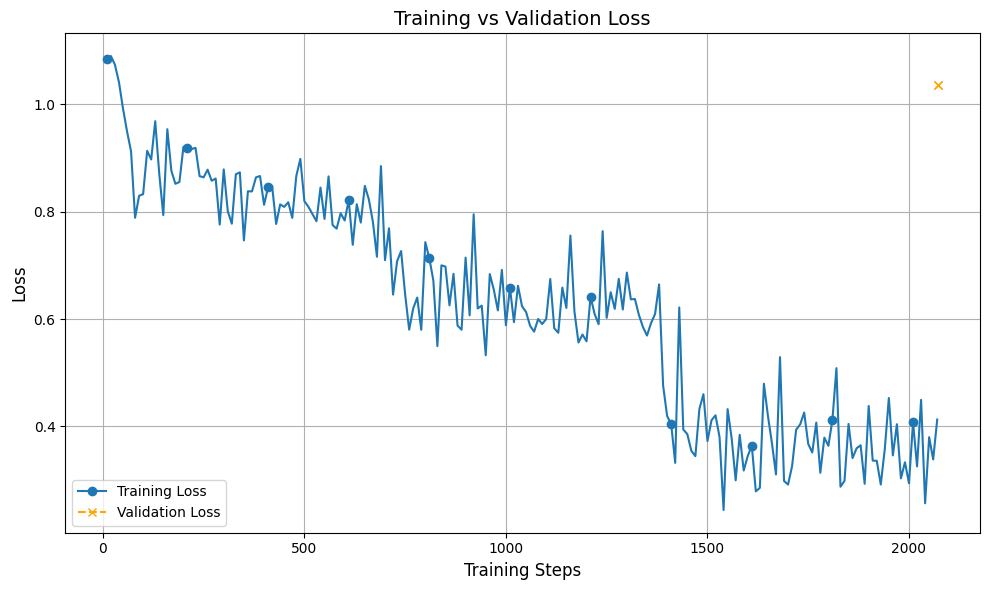

In [41]:
import matplotlib.pyplot as plt

# Extract log history
logs = trainer.state.log_history

# Extract training loss (usually logged every `logging_steps`)
train_loss = []
train_steps = []

# Extract eval loss (logged per eval interval, usually once per epoch)
eval_loss = []
eval_steps = []

for log in logs:
    if "loss" in log and "step" in log:
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log and "step" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# Optional: Smooth the curves if too jagged
# from scipy.ndimage import gaussian_filter1d
# train_loss = gaussian_filter1d(train_loss, sigma=1)
# eval_loss = gaussian_filter1d(eval_loss, sigma=1)

# Plot both curves
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss", marker='o', markevery=max(len(train_steps)//10, 1))
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker='x', linestyle='--', color='orange')
plt.title("Training vs Validation Loss", fontsize=14)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
import collections
collections.Counter(test_labels)


Counter({np.int64(1): 1089, np.int64(2): 912, np.int64(0): 763})

📋 Classification Report:
              precision    recall  f1-score   support

       brand       0.70      0.70      0.70       763
      female       0.65      0.63      0.64      1089
        male       0.54      0.55      0.55       912

    accuracy                           0.63      2764
   macro avg       0.63      0.63      0.63      2764
weighted avg       0.63      0.63      0.63      2764



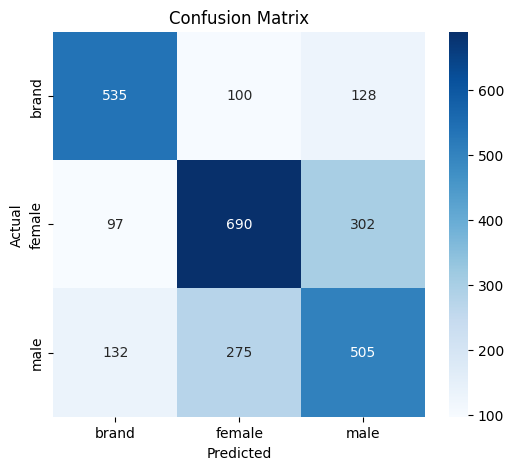

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# Get predictions from the model
predictions = trainer.predict(test_dataset)

# Extract predicted class labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Classification report
print("📋 Classification Report:")
print(classification_report(labels, preds, target_names=label_encoder.classes_))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Final Code Actions:

- Decision to change to roberta-base for better social media purposes

Roberta-Based Tweet Classifier (All-in-One)

In [47]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 1. Load Tokenizer & Model
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# 2. Re-tokenize Texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

# 3. Wrap in Custom Dataset
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

# 4. Training Arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs_roberta',
    logging_steps=10,
    report_to="none"
)

# 5. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# 6. Train
trainer.train()

# 7. Evaluate
results = trainer.evaluate()
print("Final Eval Loss (RoBERTa):", results["eval_loss"])


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.121900
20,1.106800
30,1.097800
40,1.070000
50,1.012000
60,0.910300
70,0.925900
80,0.789800
90,0.831500
100,0.875600


Step,Training Loss
10,1.121900
20,1.106800
30,1.097800
40,1.070000
50,1.012000
60,0.910300
70,0.925900
80,0.789800
90,0.831500
100,0.875600


Final Eval Loss (RoBERTa): 0.8534248471260071


    Metric	DistilBERT	RoBERTa	Notes

    Train loss (final)	~0.24	~0.43	RoBERTa started higher, but was stable

    Eval loss	~1.04	0.85	RoBERTa generalizes better

    Overfitting?	Moderate	Less	Better train–eval alignment

Step: Run RoBERTa Predictions on Test Set

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Run predictions
predictions = trainer.predict(test_dataset)

# Extract predicted labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


In [49]:
# Classification report
print("📋 Classification Report:")
print(classification_report(labels, preds, target_names=label_encoder.classes_))


📋 Classification Report:
              precision    recall  f1-score   support

       brand       0.70      0.75      0.73       763
      female       0.68      0.66      0.67      1089
        male       0.57      0.55      0.56       912

    accuracy                           0.65      2764
   macro avg       0.65      0.66      0.65      2764
weighted avg       0.65      0.65      0.65      2764



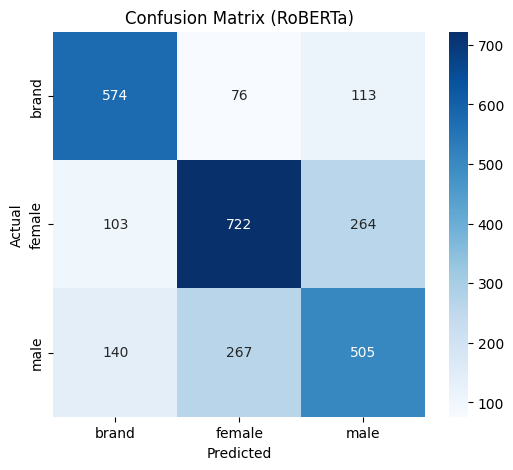

In [50]:
# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (RoBERTa)')
plt.show()
